In [ ]:
# Install necessary libraries
!pip install tensorflow opencv-python matplotlib scikit-learn seaborn flask-ngrok

# Import libraries
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Dataset path
dataset_path = "/content/drive/MyDrive/dataset/train"

# Preprocess images
def preprocess_images(path):
    images, labels = [], []
    valid_extensions = ('.jpg', '.jpeg', '.png')
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        for image_file in os.listdir(folder_path):
            if not image_file.lower().endswith(valid_extensions):
                continue
            image_path = os.path.join(folder_path, image_file)
            try:
                image = cv2.imread(image_path)
                if image is None:
                    raise ValueError(f"Image not readable: {image_path}")
                image = cv2.resize(image, (224, 224))
                images.append(image)
                labels.append(folder)
            except Exception as e:
                print(f"Error processing file {image_path}: {e}")
    images = np.array(images) / 255.0  # Normalize
    return images, labels

# Load and preprocess dataset
images, labels = preprocess_images(dataset_path)

# Encode labels
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

# Split data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")


Mounted at /content/drive
Train samples: 87, Test samples: 22


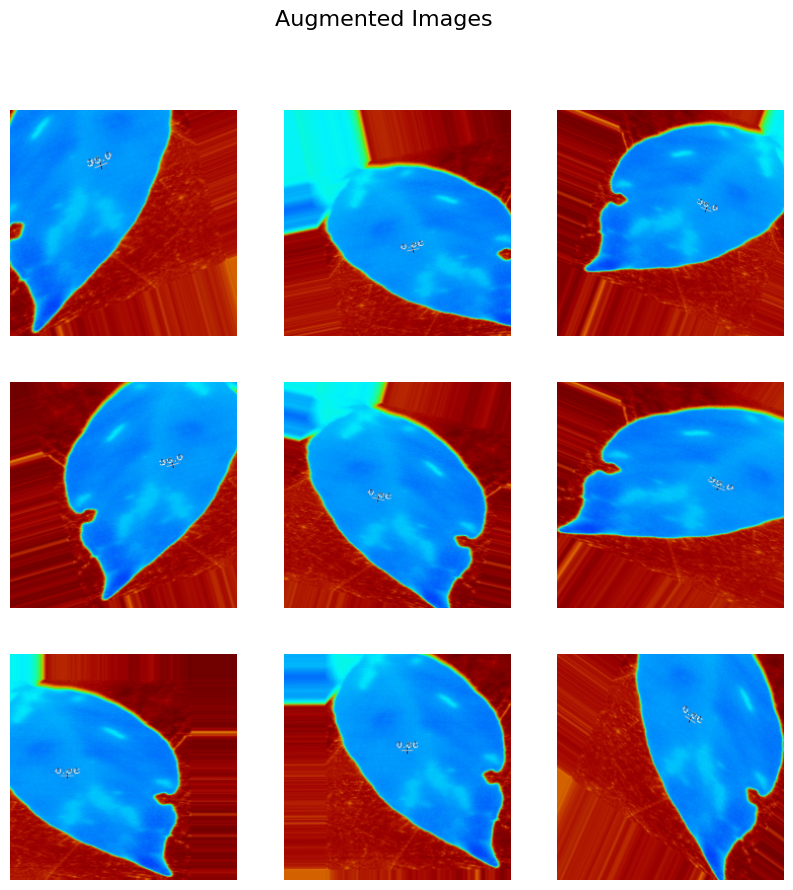

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,         # Random rotation between 0 and 30 degrees
    width_shift_range=0.2,     # Random horizontal shifts
    height_shift_range=0.2,    # Random vertical shifts
    shear_range=0.2,           # Shearing transformations
    zoom_range=0.2,            # Zoom in/out by 20%
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Fill in pixels after transformation
)

# Fit the augmentation generator on training data
datagen.fit(X_train)

# Example: Visualize augmented images
import matplotlib.pyplot as plt

# Display some augmented images
sample_image = X_train[0]  # Take the first image from the training dataset
sample_image = np.expand_dims(sample_image, axis=0)  # Add batch dimension

plt.figure(figsize=(10, 10))
for i, augmented_image in enumerate(datagen.flow(sample_image, batch_size=1)):
    if i >= 9:  # Display 9 augmented images
        break
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis('off')
plt.suptitle("Augmented Images", fontsize=16)
plt.show()


In [ ]:
# Use the data generator in training
batch_size = 32

# Create data generators for training and validation
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = datagen.flow(X_test, y_test, batch_size=batch_size)

# Train the model with augmented data
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=len(X_train) // batch_size,
    validation_steps=len(X_test) // batch_size,
    callbacks=[early_stop, model_checkpoint]
)


In [ ]:
import tensorflow as tf

# Define augmentation function
def augment(image, label):
    image = tf.image.random_flip_left_right(image)       # Random horizontal flip
    image = tf.image.random_brightness(image, 0.2)      # Random brightness
    image = tf.image.random_contrast(image, 0.8, 1.2)   # Random contrast
    image = tf.image.random_crop(image, size=[180, 180, 3])  # Random crop
    image = tf.image.resize(image, [224, 224])          # Resize back to original size
    return image, label

# Apply augmentation to the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(augment).batch(batch_size)

# Validation dataset (no augmentation)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stop, model_checkpoint]
)


In [ ]:
# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy with Augmentation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss with Augmentation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [ ]:
def build_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(np.unique(labels)), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
def build_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(np.unique(labels)), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
def build_resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(np.unique(labels)), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
def build_mobilenet():
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(np.unique(labels)), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss')

# Train and evaluate models
model = {
    # "CNN": build_cnn(),
    "VGG16": build_vgg16()
    # "ResNet50": build_resnet50(),
    # "MobileNet": build_mobilenet(),
}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...\n")
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=[early_stop, model_checkpoint]
    )

    # Evaluate model
    y_pred = model.predict(X_test).argmax(axis=1)
    print(f"\nEvaluation for {model_name}:")
    print(classification_report(y_test, y_pred, target_names=encoder.classes_))

    # Plot accuracy and loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title(f"{model_name} Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(f"{model_name} Loss")
    plt.show()


In [ ]:
# ROC Curve
def plot_roc_curve(y_true, y_proba, num_classes):
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve([1 if label == i else 0 for label in y_true], [p[i] for p in y_proba])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

# Confusion Matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Example usage
y_proba = models["ResNet50"].predict(X_test)
y_pred = y_proba.argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)

plot_roc_curve(y_test, y_proba, len(np.unique(labels)))
plot_confusion_matrix(cm, encoder.classes_)


In [ ]:
from flask import Flask, request, jsonify
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)

# Load trained model
model = models["ResNet50"]  # Example model

@app.route('/predict', methods=['POST'])
def predict():
    file = request.files['file']
    img = cv2.imdecode(np.frombuffer(file.read(), np.uint8), cv2.IMREAD_COLOR)
    img = cv2.resize(img, (224, 224)) / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img).argmax(axis=1)
    response = {
        "prediction": int(prediction),
        "class_name": encoder.classes_[int(prediction)]
    }
    return jsonify(response)

app.run()
